# Regularization, Feature Scaling and Cross Validation

The program consists of two parts that interact with each other. We will call these parts the **teacher** and the **student**. 
Fhe **teacher** picks a **beta_star** vector, that corresponds to some green polynomial line and generates points around it with standard deviation **sigma**. The techer calls these points **x_1**, and **y_1** where x_1 and y_1 are vectors. The teacher also generates another set of points called **x_2** and **y_2**. The techer is going to give **x_1** and **y_1** for the student to learn and also gives **x_2**, BUT NOT **y_2** to the student to test the output.


The **student**, takes the **x_1** and **y_1** values of the points but does not know the degree of the polynomial the teacher used. The **student** has just learned regularization and wants to use that in this problem. That's why instead of trying multiple values for **d_train** the student decides to use **ONLY** **d_train** = 9 and use **lambda** to see if he can avoid overfitting using regularization. The student also knows, that because he wants his regularization to work well, then he needs to scale and standardize his data. To do so, when the student constructs the **X** matrix with polynomial degrees, he then does features scaling to get a new matrix **X_scaled**. To do so, the student calculates the mean and standard deviation (**mu** and **sigma**) for each COLUMN of **X** and does feature scaling as learned in class.

There is another question, however, how do you choose **lambda** ? The student decides that he will try multiple values for **lambda** and see which one will give him the best cross validation score. He will use **k** fold cross validation with **num_trials** random shufflings of the data, and determine the **BEST** lambda to use for the regression. When he determins the best **lambda** he will use that **lambda** to train the model on the entire **x_1**, **y_1** dataset and then apply the result on the **x_2** do determine **y_2_predicted** and return that to the teacher. The student will also print out cross validation scores for many values of the **lambda**.

Extra: the student realizses, that since he used feature scaling, the **beta_hat** he received at the end will be meaningless for the teacher. Because teacher's coordinate system is different. Can the student find a way to construct **beta_hat_for_techer** using the **beta_hat** which will make sense to the teacher? 


After the teacher receives the **y_2_predicted**, the techer will compare that to **y_2** to see how well the student learned.








In [6]:
%config IPCompleter.greedy=True
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils  import  shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing  import  StandardScaler

In [7]:
#transforms x into d+1 columns
def transform_x(x, d):
    return np.column_stack([x**i for i in range(d+1)])

In [8]:
# assumes X,Y are numpy arrays
def linear_regression(X,Y,lam):
    reg = lam*np.eye(len(X[0]))
    reg[0][0] = 0
    return np.linalg.inv(X.T.dot(X) + reg).dot(X.T).dot(Y)

### Teacher


In [9]:
# generate some points for the student
def generate_points_polynomial(xmin, xmax, num_points, sigma,  beta_star, d_star):
    x_vec = np.random.uniform(xmin, xmax, num_points)
    x = transform_x(x_vec, d_star)
    y_gold = []
    for x_i in x:
        y_gold.append(beta_star@x_i)
    y = np.random.normal (y_gold, sigma).T
    return np.array(x_vec), np.array(y)

### Student

In [112]:
#this is the function by which the student and the teacher interact
#this function should call cross_validation multiple times to get 
# cross validation scores for multiple lambdas and prints the scores.
# It then needs to determine the best lambda.
# when the best lambda is chosen, the student runs a regression with 
# that lambda, on the entire (x,y) data to get the beta_hat 
# to calculate y_2_predicted. To do so the student first need to scale X matrix into X_scaled so that
# his regularization works. running regression on (X_scaled, y) will give beta_scaled 
# which the student can use to calculate y_2_predicted on X_2_scaled. 
# Student then returns the y_2_predicted

# Extra: beta_scaled will be meaningless for the teacher because the teacher does not know how student scales X.
# that's why there is no point for the student to return beta_scaled
# Is there a way for the student to calculate beta_hat using the beta_scaled?
# To find this you need to use pen and paper and try to understand what the relationship is 
# Hint X.dot(beta_hat) = X_scaled.dot(beta_scaled) for ANY X.
# if you can find this, also return beta_hat to the teacher 
def feature_scale(x):
    scaler = StandardScaler()
    scaler.fit(x[ :, 1:])
    x_norm = scaler.transform (x[ :, 1:])
    X_scaled = (np.concatenate((x[ :, :1].T, x_norm.T), axis=0)).T
    return X_scaled

def fit_best_polynomial(x, y, x_2 = 0, k = 10, num_trials = 50, d=9):
    x = transform_x(x, d)
    x_norm = feature_scale(x)
    x_2 = transform_x(x_2, d)
    x_2_norm = feature_scale(x_2)
    best_lam = float('Inf')
    error = float('Inf')
    beta_scaled = []
    costs = {}
    #lam = 0.0001
    lams = [0.0001, 0.001, 0.01, 0.1 , 0.2 , 0.3 ,0.5 , 1, 5, 10]
    #lams = [0.001, 0.01, 0.1 , 10 , 20/3 , 4.444444, 2.96, 1.97, 1.32, 0.58, 0.39, 0,26 , 0.17, 0.11]
    for lam in lams:
    #while lam < 11:
        err_i, beta_i = cross_validation(x_norm, y, lam, k, num_trials)
        costs[lam] = err_i
        if error > err_i:
            error = err_i
            best_lam = lam
            beta_scaled = beta_i
        #lam = lam*10
    y_2_predicted = x_2_norm@beta_scaled
    beta_hat = np.linalg.inv(x[ : d+1])@x_norm[ : d+1]@beta_scaled
    return y_2_predicted, costs#,  beta_hat

In [109]:
# This is the function that performs the feature scaling, regression and cross validation 
# First for num_trials different times x,y are shuffled and then k-fold cross validation is done
# FOR EACH of the num_trials * k cases, you need to train a regression model of train_data and then test it
# for test_data right? that means each of these cases have to be scaled separately.
# that's why we add another two functions to use
# feature_scale_train(X) that returns the scaled X as well as two vectors
# mu_vec and sigma_vec which contain the averages and sigmas for each column of X. 
# and deature_scale_test(X, mu_vec, sigma_vec) where it will use
# sigma_vec and mu_vec to scale the test_data THE SAME WAY as the train data was scaled.
def cross_validation (x, y, lam, k=10, num_trials=100):
    kf = KFold(n_splits=k)
    error = num_trials*[0]
    beta_hat = []
    for i in range(num_trials):
        x, y = shuffle(x, y)
        err_i = []
        for train, test in kf.split(x, y):
            train_x = []
            test_x = []
            train_y = []
            test_y = []
            train_x.append([x[train_i] for train_i in train])
            test_x.append([x[test_i] for test_i in test])
            train_y.append([y[train_i] for train_i in train])
            test_y.append([y[test_i] for test_i in test])
            train_x = np.array(train_x[0])
            train_y = np.array(train_y[0])
            test_x = np.array(test_x[0])
            test_y = np.array(test_y[0])
            
            beta_hat = linear_regression(train_x, train_y, lam)
            err_i.append([(test_x[i]@beta_hat - test_y[i])**2 for i in range(len(test))])
        error[i] = np.mean(err_i)
    return np.mean(error), beta_hat

C:\Users\serge\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


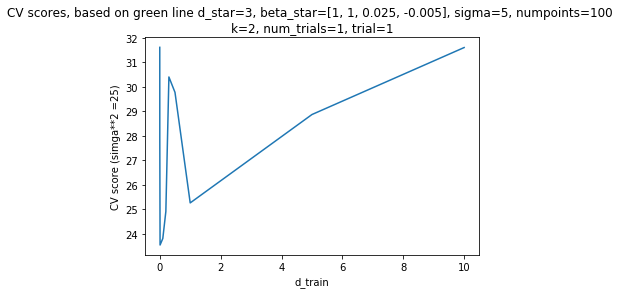

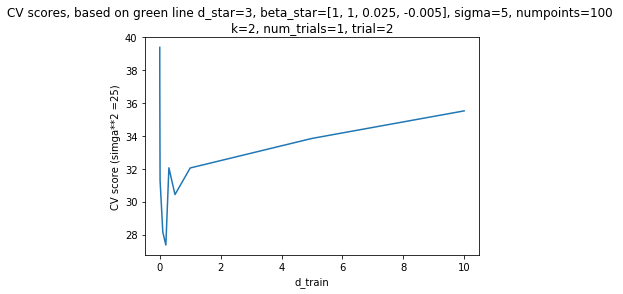

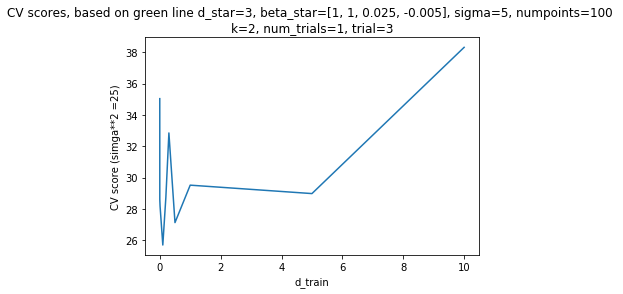

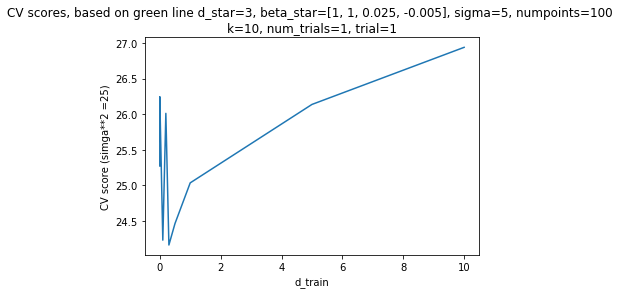

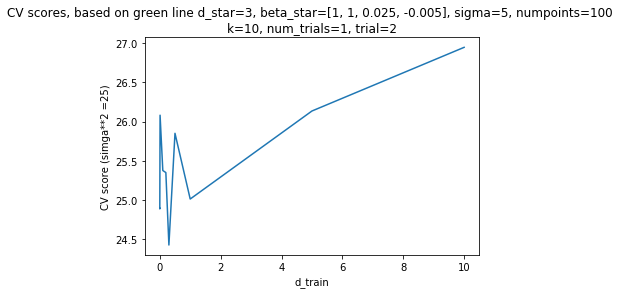

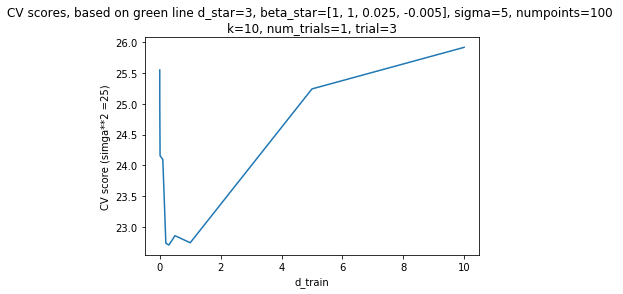

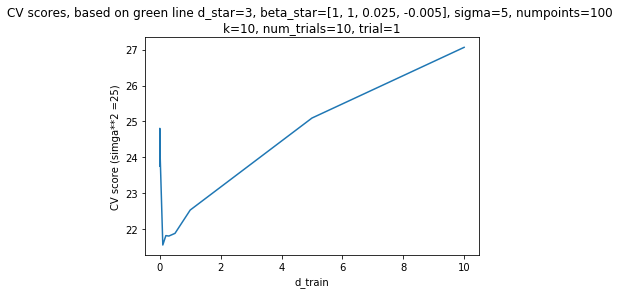

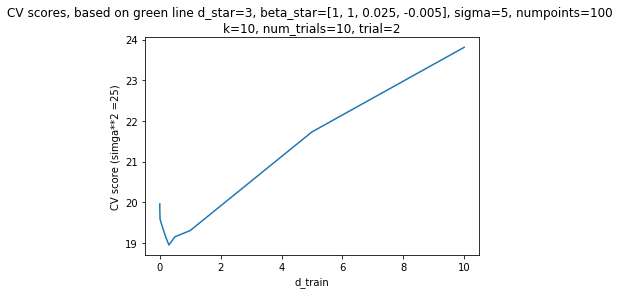

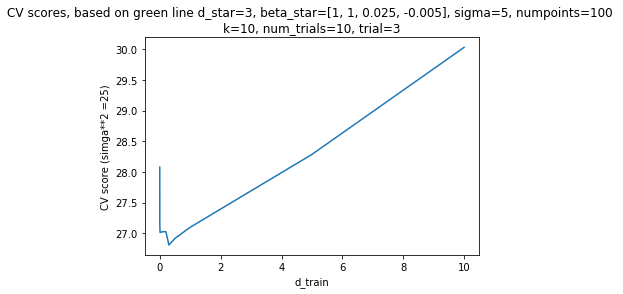

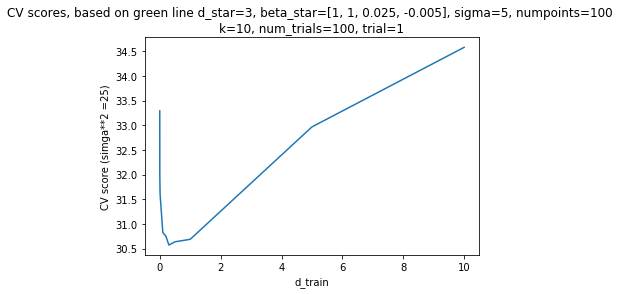

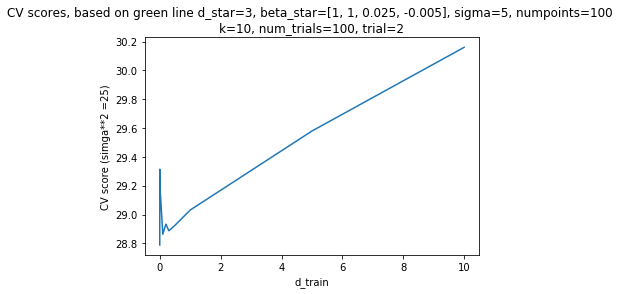

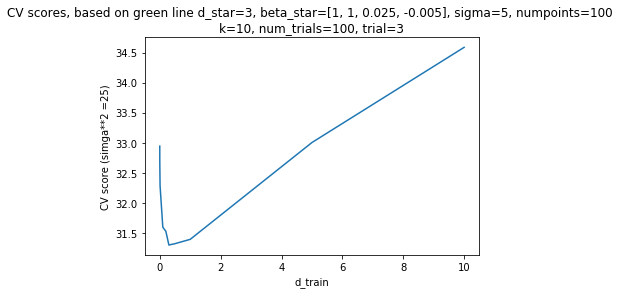

In [113]:
xmin = -15
xmax = 20
num_points = 100
sigma = 5
d_star = 3
beta_star = [1, 1, 0.025, - 0.005]
li = [(2,1),(10,1),(10,10),(10,100)]
for (k,num_trials) in li:
    for trial in range(3):
        x,y = generate_points_polynomial(xmin, xmax, num_points, sigma,  beta_star, d_star)
        y_predict, scores = fit_best_polynomial(x,y,0,k,num_trials)
        plt.plot(scores.keys(),scores.values())
        plt.title("CV scores, based on green line d_star=%s, beta_star=%s, sigma=%s, numpoints=%s \nk=%s, num_trials=%s, trial=%s" % (d_star,beta_star,sigma, num_points,k,num_trials,trial+1))
        plt.xlabel("d_train")
        plt.ylabel("CV score (simga**2 =%s)" % sigma**2)
        plt.show()

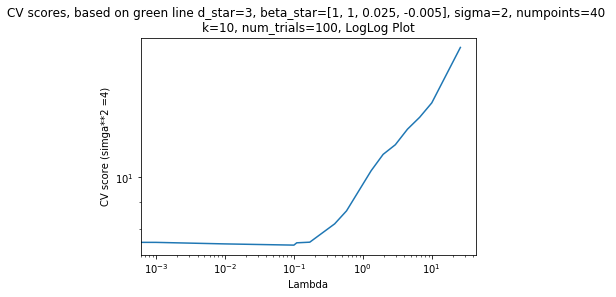

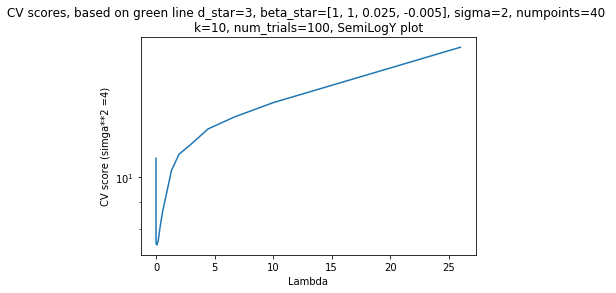



Best lambda is 0.1 with a score 7.466203613730012








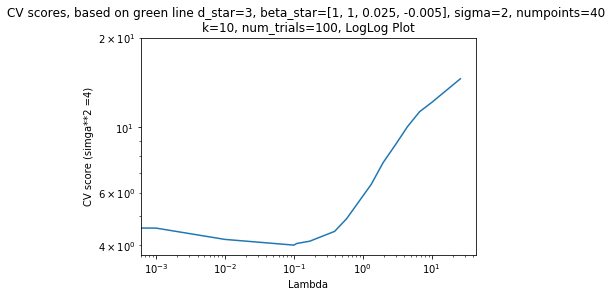

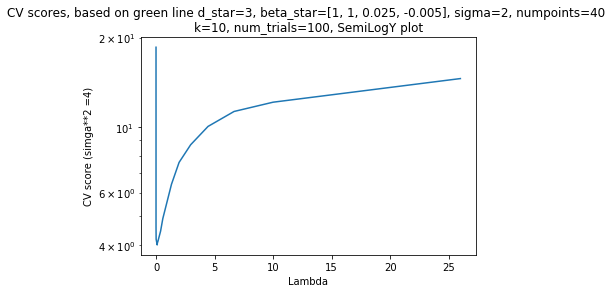



Best lambda is 0.1 with a score 3.9980666437846755








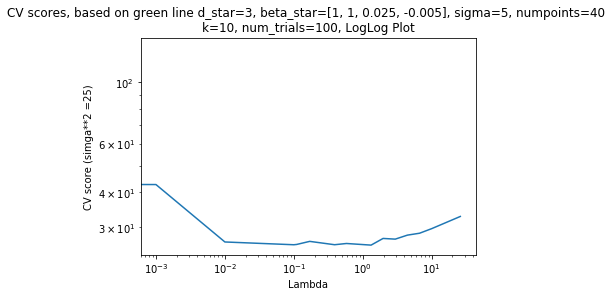

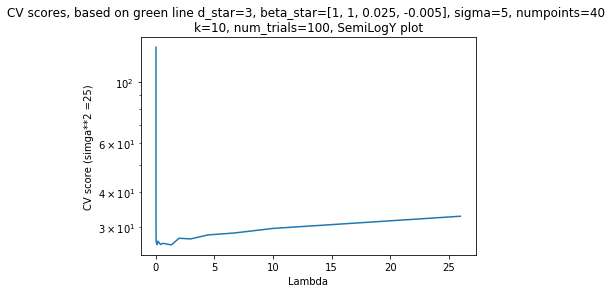



Best lambda is 1.32 with a score 25.833288456710523








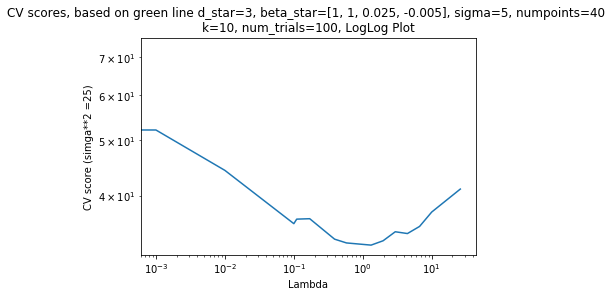

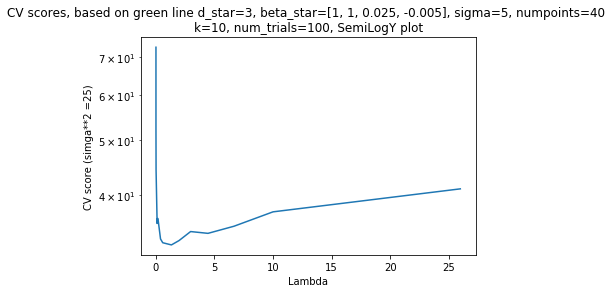



Best lambda is 1.32 with a score 32.73696787683164








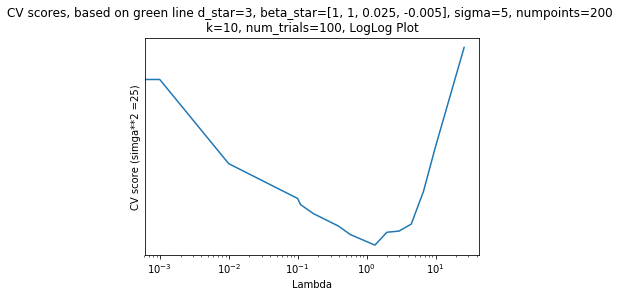

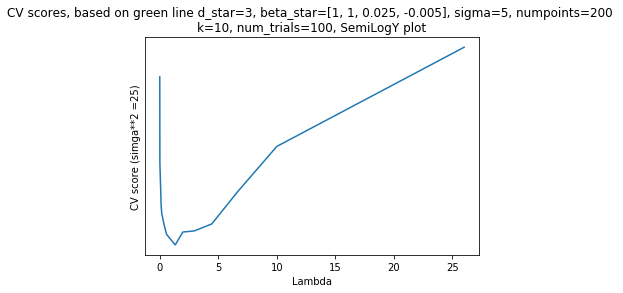



Best lambda is 1.32 with a score 31.897168652226682








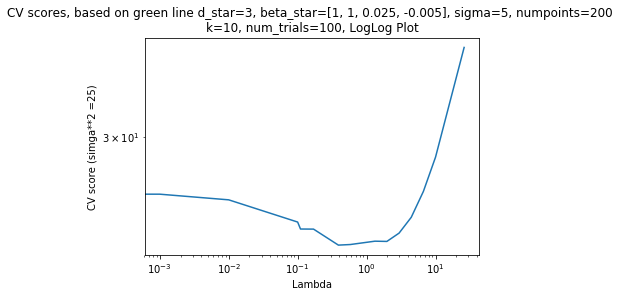

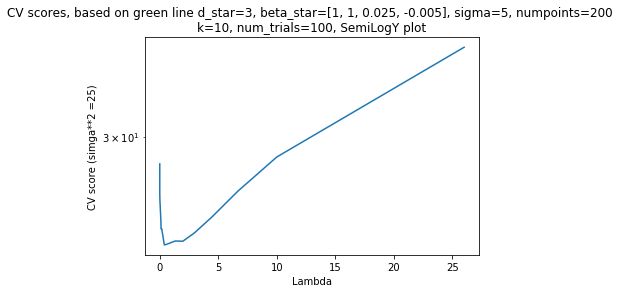



Best lambda is 0.39 with a score 28.25392577060672








In [110]:
xmin = -15
xmax = 20
d_star = 3 
beta_star = [1, 1, 0.025, - 0.005]
sigma = 2
num_points = 40
li = [(40,2), (40,2), (40,5), (40,5), (200,5), (200,5)]
lams = [0.001, 0.01, 0.1 , 10 , 20/3 , 4.444444, 2.96, 1.97, 1.32, 0.58, 0.39, 0,26 , 0.17, 0.11]
for num_points, sigma in li:
    x_1, y_1 = generate_points_polynomial(xmin, xmax, num_points, sigma,  beta_star, d_star)
    x_2, y_2 = generate_points_polynomial(xmin, xmax, num_points, sigma,  beta_star, d_star)
    y_2_predicted, scores = fit_best_polynomial(x_1, y_1, x_2)
    a = sorted(scores.items())
    xx,yy = zip(*a)
    plt.loglog(xx, yy)
    plt.title("CV scores, based on green line d_star=%s, beta_star=%s, sigma=%s, numpoints=%s \nk=10, num_trials=100, LogLog Plot" % (d_star,beta_star,sigma, num_points,))
    plt.xlabel("Lambda")
    plt.ylabel("CV score (simga**2 =%s)" % sigma**2)
    plt.show()
    
    plt.semilogy(xx,yy)
    plt.title("CV scores, based on green line d_star=%s, beta_star=%s, sigma=%s, numpoints=%s \nk=10, num_trials=100, SemiLogY plot" % (d_star,beta_star,sigma, num_points,))
    plt.xlabel("Lambda")
    plt.ylabel("CV score (simga**2 =%s)" % sigma**2)
    plt.show()
    best_lam = min(scores, key=scores.get)
    print("\n")
    print("Best lambda is", best_lam, "with a score", scores[best_lam])
    print("\n")
    print("\n")
    print("\n")

In [ ]:
xmin = -15
xmax = 20
d_star = 3  
beta_star = [1, 1, 0.025, - 0.005]
sigma = 5
num_points = 50
x_1, y_1 = generate_points_polynomial(xmin, xmax, num_points, sigma,  beta_star, d_star)
x_2, y_2 = generate_points_polynomial(xmin, xmax, num_points, sigma,  beta_star, d_star)
y_2_predicted, beta_hat = fit_best_polynomial(x_1, y_1,k, num_trials, x_2)
x_line = np.linspace(xmin, xmax, num_points)
scores1 = transform_x(x_line, 9)
plt.plot(x_line, y_2_predicted)
plt.title("CV scores, based on green line d_star=%s, beta_star=%s, sigma=%s, numpoints=%s \nk=%s, num_trials=%s, trial=%s" % (d_star,beta_star,sigma, num_points,k,num_trials,trial+1))
plt.xlabel("d_train")
plt.ylabel("CV score (simga**2 =%s)" % sigma**2)
plt.show()

In [ ]:
xmin = -15
xmax = 20
d_star = 3 
beta_star = [1, 1, 0.025, - 0.005]
sigma = 5
num_points = 50
x_1, y_1 = generate_points_polynomial(xmin, xmax, num_points, sigma,  beta_star, d_star)
x_2, y_2 = generate_points_polynomial(xmin, xmax, 10*num_points, sigma,  beta_star, d_star)
beta_hat, y_2_predicted = fit_best_polynomial(x_1, y_1, x_2)
    #X = transform_x(x_line, d_train)
    #y_line = X@beta_hat

In [ ]:
# IMPORTANT since the 0th column of X is 1's we will NOT scale the 0th column. (Hint: set mu_vec[0] to 0 and 
# sigma_vec[0] to 1)
def feature_scale(X):
    scaler = StandardScaler()
    scaler.fit(x[ :, 1:])
    x_norm = scaler.transform (x[ :, 1:])
    X_scaled = (np.concatenate((x[ :, :1].T, x_norm.T), axis=0)).T
    return X_scaled#, mu_vec, sigma_vec
# def feautre sclae_test(X, mu_vec, sigma_vec):
#     return X_scaled